In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pickle
import datetime
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from importlib import reload
#import after torch else crash on Intel
from scipy.optimize import least_squares

from libs_unet.models import mw_peakyfinder_0006
from libs_unet.training.spec_maker import spectrum_maker

top_dir = Path.cwd()
datapath = top_dir / 'data'

In [73]:
#Load model and parameters for making predictions
#https://pytorch.org/tutorials/beginner/saving_loading_models.html
#['H','Li','B','C','N','O','F','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca']
mw_max_z = 17
wave = range(180,962,1)
model = mw_peakyfinder_0006.LIBSUNet(mw_max_z,len(wave)) #trained on 17 elements
param_path = top_dir / 'trained_models' / 'mw_earthabund_50k'
model.load_state_dict(torch.load(param_path))


<All keys matched successfully>

In [74]:
#check if this model can identify elements in Li2CO3
with open(datapath / 'training' / 'el80_pairs_meta.pickle', 'rb') as f:
    wave = pickle.load(f)
    elem_symb = pickle.load(f)
    el_index = pickle.load(f)

max_z = len(elem_symb)
spec_maker = spectrum_maker()
fracs_dict = {'Li':0.333, 'C':0.167, 'O':0.5}
wave, spec_dict, lines_dict = spec_maker.make_spectra(fracs_dict)

y_custom = np.zeros((max_z + 2, len(wave)))
for el in spec_dict.keys():
    if el == 'art':
        y_custom[max_z] = spec_dict[el]
    elif el == 'noi':
        y_custom[max_z + 1] = spec_dict[el]
    elif el == 'comp':
        x_custom = spec_dict['comp']
    else:
        y_custom[el_index[el]] = spec_dict[el]

In [75]:
max_peak = np.max(x_custom)
max_peak

8637.653354471775

In [76]:
#scale and dimension data for model
x_custom = 1000* x_custom / max_peak
y_custom = 1000 * y_custom / max_peak
x_custom = torch.tensor(x_custom[None,None,:].astype('float32'))
y_custom = torch.tensor(y_custom[None,:,:].astype('float32'))
#x_custom[x_custom < 0] = 0
#y_custom[y_custom < 0] = 0

model.eval()
with torch.no_grad():
    y_pred = model(x_custom).detach().numpy().squeeze().copy()


Sample composition
Li:0.333
C:0.167
O:0.5


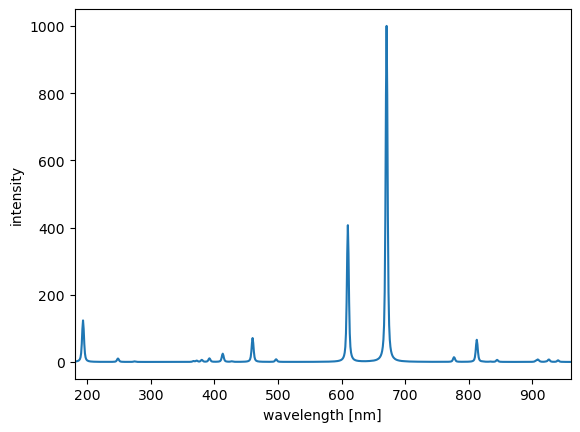

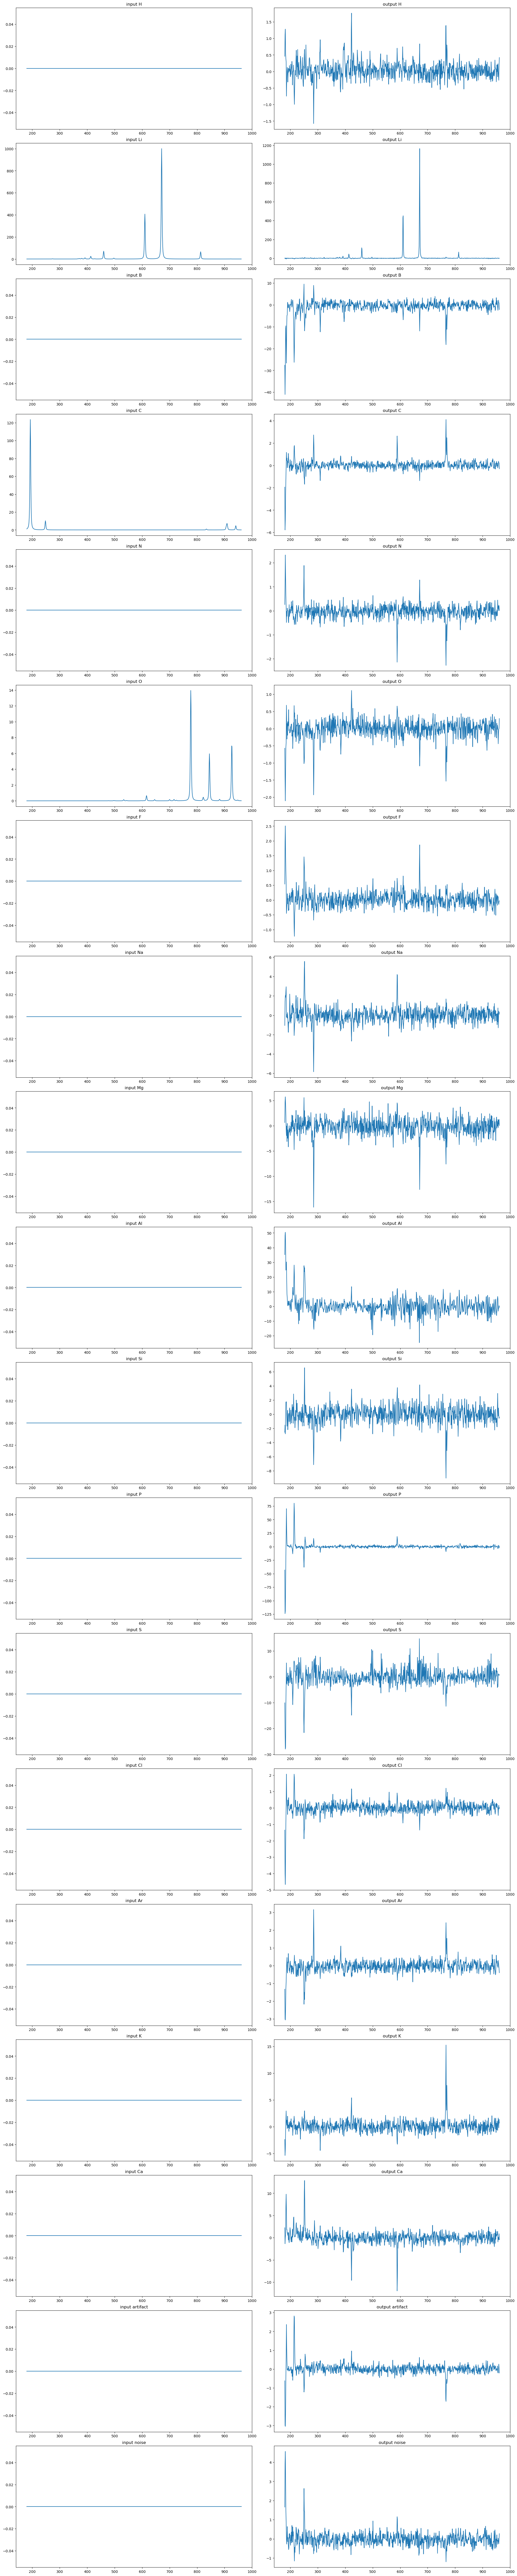

In [79]:
#look at the predicted vs. reference spectra
#mw used a custom set of elements we define
mw_elem = np.array(['H','Li','B','C','N','O','F','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca'])

print("Sample composition")
for k,v in fracs_dict.items():
    print(f"{k}:{v}")

        
#first plot the scaled composite input spectrum we're trying to decompose
plt.plot(wave, x_custom[0][0])
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([np.min(wave), np.max(wave)])
plt.show

#https://matplotlib.org/3.5.0/tutorials/introductory/usage.html#the-object-oriented-interface-and-the-pyplot-interface
def pred_plot(ax, data1, data2, param_dict):
    out = ax.plot(data1, data2, **param_dict)
    return out

rows = 19
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(20,100), constrained_layout=True)
plot_row = 0
plot_col = 0
for i in range(mw_max_z + 2): #iterate over rows in pred array
    custom_ind = ''
    if i < mw_max_z:
        axs[i][0].set_title(f"input {mw_elem[i]}")
        axs[i][1].set_title(f"output {mw_elem[i]}")
        custom_ind = [el_index[mw_elem[i]]]
    elif i == mw_max_z:
        axs[i][0].set_title('input artifact')
        axs[i][1].set_title('output artifact')
        custom_ind = i
    else:
            axs[i][0].set_title('input noise')
            axs[i][1].set_title('output noise')
            custom_ind = i
   
    axs[i][0].plot(wave, y_custom[0][custom_ind].squeeze())        
    axs[i][1].plot(wave, y_pred[i])


In [34]:
y_pred.shape


(1, 19, 782)